This task was a sentiment classification task based on the IMDB movie reviews. I performed the task to better understand how word embeddings can be used to represent words in a lower-dimensional space as an alternative to one-hot encoding which results in very sparse, very high-dimensional vector representations of words

In [142]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras import models
import numpy as np
import matplotlib.pyplot as plt

In [143]:
import os

imdb_dir = './aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = list()
texts = list()

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [191]:
maxlen = 100 #keep only the last 100 elements of every vector sequence
training_samples = 2000 #train on only 2000 reviews
validation_samples = 10000 #validate on 10000 reviews
max_words = 1000 #Restrict dictionary to the 1000 most common words across all reviews

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index #dictionary of unique words

In [192]:
print('Found {0} unique words'.format(len(word_index)))

Found 87393 unique words


In [193]:
data = pad_sequences(sequences, maxlen=maxlen)

In [194]:
labels = np.asarray(labels)

In [195]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [196]:
indices = np.arange(data.shape[0])
indices

array([    0,     1,     2, ..., 24997, 24998, 24999])

In [197]:
np.random.shuffle(indices)
indices

array([19205, 18715, 14689, ..., 10237, 23350,  2421])

In [198]:
data = data[indices]
labels = labels[indices]

In [199]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

In [200]:
y_train

array([1, 1, 1, ..., 0, 0, 1])

In [116]:
#Next we import the Stanford GloVe directory

glove_dir = './glove/'
embeddings_index = dict()

f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' %len(embeddings_index))

Found 400000 word vectors


In [154]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [219]:
#A dropout is added after every layer to reduce overfitting

model = models.Sequential()

model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.Dropout(0.3))
#model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32))
model.add(layers.Dropout(0.3))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 100, 300)          300000    
                                                                 
 gru_44 (GRU)                (None, 100, 32)           32064     
                                                                 
 dropout_1 (Dropout)         (None, 100, 32)           0         
                                                                 
 gru_45 (GRU)                (None, 100, 32)           6336      
                                                                 
 dropout_2 (Dropout)         (None, 100, 32)           0         
                                                                 
 gru_46 (GRU)                (None, 32)                6336      
                                                                 
 dropout_3 (Dropout)         (None, 32)              

In [220]:
model.layers

In [138]:
#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

In [221]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/15
63/63 [==============================] - 13s 146ms/step - loss: 0.6547 - acc: 0.6090 - val_loss: 0.5815 - val_acc: 0.6891
Epoch 2/15
63/63 [==============================] - 8s 128ms/step - loss: 0.4771 - acc: 0.7710 - val_loss: 0.5709 - val_acc: 0.6903
Epoch 3/15
63/63 [==============================] - 8s 135ms/step - loss: 0.3718 - acc: 0.8425 - val_loss: 0.5392 - val_acc: 0.7351
Epoch 4/15
63/63 [==============================] - 8s 134ms/step - loss: 0.2998 - acc: 0.8805 - val_loss: 0.5573 - val_acc: 0.7486
Epoch 5/15
63/63 [==============================] - 9s 138ms/step - loss: 0.2429 - acc: 0.9070 - val_loss: 0.5795 - val_acc: 0.7508
Epoch 6/15
63/63 [==============================] - 9s 137ms/step - loss: 0.1743 - acc: 0.9400 - val_loss: 0.7307 - val_acc: 0.7697
Epoch 7/15
63/63 [==============================] - 8s 132ms/step - loss: 0.1492 - acc: 0.9480 - val_loss: 0.8133 - val_acc: 0.7572
Epoch 8/15
63/63 [==============================] - 8s 135ms/step - loss: 0

In [222]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

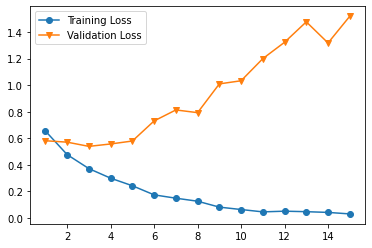

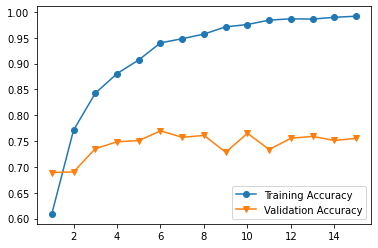

In [223]:
epochs = list(np.linspace(1, len(history_dict['loss']), len(history_dict['loss'])))

training_loss = history_dict['loss']
training_acc = history_dict['acc']
validation_loss = history_dict['val_loss']
validation_acc = history_dict['val_acc']

plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='v', label='Validation Loss')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, training_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, validation_acc, marker='v', label='Validation Accuracy')
plt.legend()
plt.show()

In [224]:
test_dir = os.path.join(imdb_dir, 'test')

labels = list()
texts = list()

for label_type in ['neg','pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [225]:
sequences = tokenizer.texts_to_sequences(texts)

In [226]:
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [227]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 11s 14ms/step - loss: 1.3956 - acc: 0.7722


[1.395646572113037, 0.7721999883651733]